# CS498PS - Lab 2: Filter Design and Usage

For this lab you will learn how to design some simple filters and how to apply them to solve some common audio problems. Python’s scipy.signal package has an extensive set of commands to help you design filters (firwin, firwin2, butter, cheby1, cheby2,  ellip, …), so there is no shortage of options.

## Part 1: When to use what 

There will be four cases to this part, each requiring a different type of filter to address a problem in a recording.  The input recordings are:

- ```case1.wav``` [https://drive.google.com/uc?export=download&id=1eTsDiXqqLQv3murPz25O54E89i3DL__d ] : A noise-corrupted speech signal. We want to eliminate the noise.
- ```case2.wav``` [https://drive.google.com/uc?export=download&id=1egd22CxPUe6sINIi0FPTbMfG4S_In2hT ] : Same as above, different type of noise. We want to remove the noise again.
- ```case3.wav``` [https://drive.google.com/uc?export=download&id=1eF-VOVWoT1rh1wAC06WT1ANusMKyDYSn ] : Bird songs during a thunderstorm. As a world renowned ornithologist you need to have a cleaner recording of the bird songs for further analysis.
- ```case4.wav``` [https://drive.google.com/uc?export=download&id=1eeizGhrBICf6pW5OXcbq7ChF4m2N6yIk ]: The signal that we require to extract here is a Morse code which is buried in environmental noise. Design a filter to bring out the beeps.

For each case do the following:
- Plot the spectrogram of the given sound and identify the problem
- Describe what kind of filter will address this problem and why
- Design an FIR filter using ```scipy.signal.firwin()``` and/or ```scipy.signal.firwin2()```
- Design an FIR filter using the formulas in my slides (i.e. do not use ```scipy.signal```)
- Design an IIR Butterworth filter using ```scipy.signal```'s routines
- Show a plot comparing the response of all the filters (hint: ```scipy.signal.freqz```)
- Plot spectrograms of the filtered recordings and compare with the input to show that it fixed the problem
- Play the filtered sounds so that we can hear how well it works

Make some observations on how the results differ between an FIR and IIR filter and try to find the best possible filter size/type/parameters to produce the best result. Show results under various parameters (e.g. filter length) and make some plots that demonstrate the effects of these parameters. Most importantly, try to get a sense of how these design choices impact audible quality. Being able to listen at a sound and identify what’s wrong and how to fix it is a big part of audio processing.

Hint: To apply an FIR filter you can use ```scipy.signal.convolve```, to apply an IIR filter (or an FIR) you can use ```scipy,signal.lfilter```.


#### Original sounds and spectrogram ####

case1: low pass filter should be applied to filter the high freqency noise.


case2: band stop filter should be applied to filter the ring sound at specific frequencies.


case3: high pass filter should be applied to filter the low frequency storm sound.


case4: band pass filter should be applied to extract the sound of morse code.


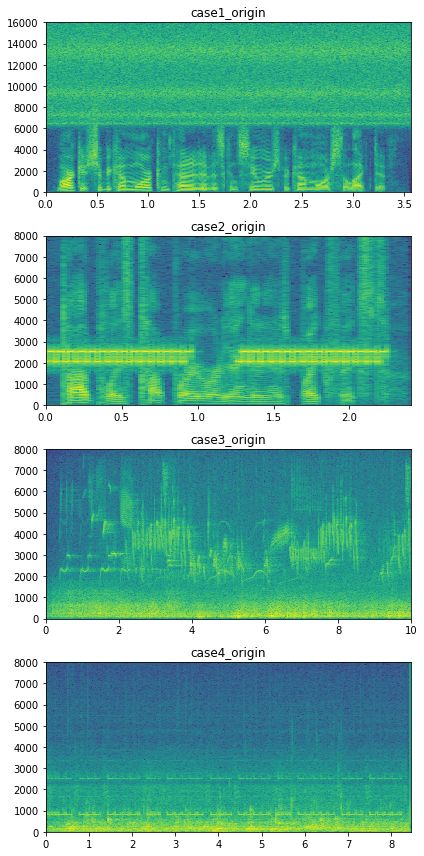

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy import signal
from copy import deepcopy
import math

def stft(input_sound, dft_size, hop_size, zero_pad, window):
    result = []
    for i in range(0, len(input_sound), hop_size):
        slot = []
        start = i
        end = i + dft_size
        if end >= len(input_sound):
            slot = input_sound[start:]
            zero = np.array([0] * (end - len(input_sound)))
            slot = np.concatenate([slot, zero])
        else:
            slot = input_sound[start:end]
        result.append(np.fft.rfft(np.concatenate([np.multiply(slot, window), np.array(zero_pad)])))
    return result

def istft(stft_output, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    result = np.array([0] * (hop_size * len(stft_output) - hop_size + dft_size))
    for i in range(len(stft_output)):
        each_wave = np.fft.irfft(stft_output[i], n=dft_size + len(zero_pad))[:dft_size]
        result[(i * hop_size):(i * hop_size + dft_size)] = np.add(result[(i * hop_size):(i * hop_size + dft_size)], np.multiply(window, each_wave))
        
    # Return reconstructed waveform
    return result[:hop_size * len(stft_output)]

def show_graph(fig, freq_data, amp_data_len, sample_rate, mode="spectrogram", title=""):
    if mode == "spectrogram":
        transposed_data = np.log(np.absolute(freq_data).real).T
        t1 = np.linspace(0, amp_data_len / sample_rate, len(transposed_data[0]))
        t2 = np.linspace(0, sample_rate / 2, len(transposed_data))
        x1, x2 = np.meshgrid(t1, t2)
        fig.pcolormesh(x1, x2, np.array(transposed_data))
        fig.set_title(title)
        
def show_response(fig, freqz, title=""):
    fig.plot(freqz[0], abs(freqz[1]))
    fig.set_title(title)

        
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        

# Load the sound, play it, and plot it's spectrogram
# YOUR CODE HERE
        
sr1, data1 = read("case1.wav")
sr2, data2 = read("case2.wav")
sr3, data3 = read("case3.wav")
sr4, data4 = read("case4.wav")

sound( data1, rate=sr1, label='case1.wav')
print("case1: low pass filter should be applied to filter the high freqency noise.")
sound( data2, rate=sr2, label='case2.wav')
print("case2: band stop filter should be applied to filter the ring sound at specific frequencies.")
sound( data3, rate=sr3, label='case3.wav')
print("case3: high pass filter should be applied to filter the low frequency storm sound.")
sound( data4, rate=sr4, label='case4.wav')
print("case4: band pass filter should be applied to extract the sound of morse code.")

dft_size = 1024
hop_size = 256 
zero_pad = []
window = signal.triang(dft_size)

fig, (fig1_origin_spec, fig2_origin_spec, 
      fig3_origin_spec, fig4_origin_spec) = plt.subplots(nrows=4)

origin_freq_1 = stft(data1, dft_size, hop_size, zero_pad, window)
origin_freq_2 = stft(data2, dft_size, hop_size, zero_pad, window)
origin_freq_3 = stft(data3, dft_size, hop_size, zero_pad, window)
origin_freq_4 = stft(data4, dft_size, hop_size, zero_pad, window)

show_graph(fig1_origin_spec, origin_freq_1, len(data1), sr1, "spectrogram", "case1_origin")
show_graph(fig2_origin_spec, origin_freq_2, len(data2), sr2, "spectrogram", "case2_origin")
show_graph(fig3_origin_spec, origin_freq_3, len(data3), sr3, "spectrogram", "case3_origin")
show_graph(fig4_origin_spec, origin_freq_4, len(data4), sr4, "spectrogram", "case4_origin")

fig.set_size_inches(6, 12)
fig.tight_layout()
plt.show()

#### Applying filters generated by scipy.signal ####

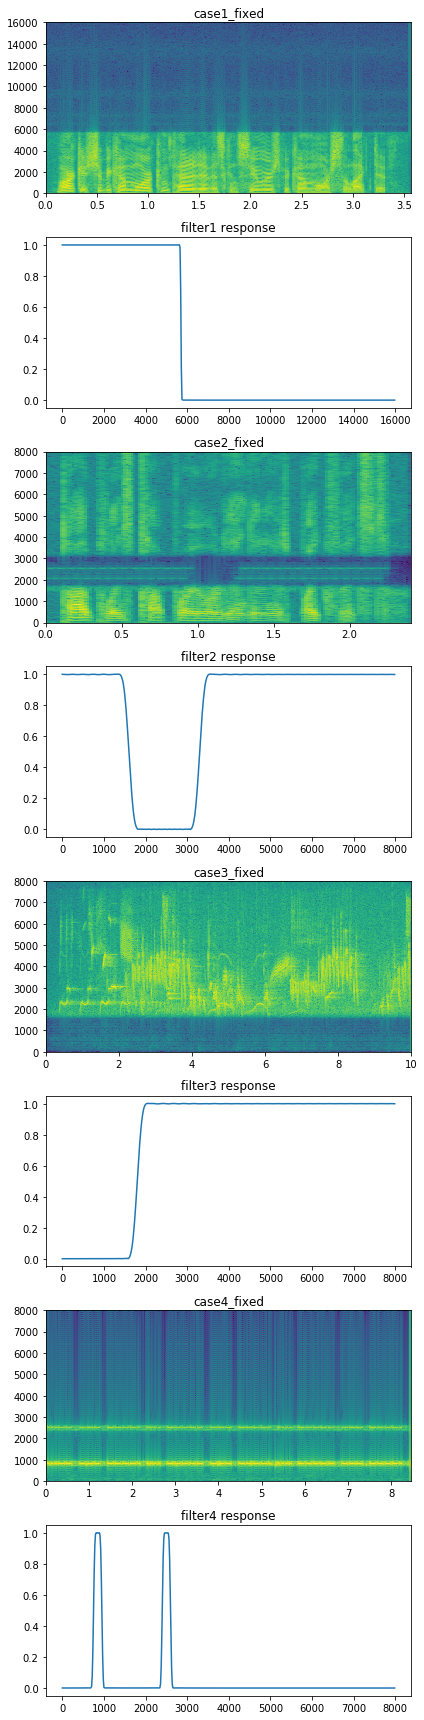

In [17]:
fig, (fig1_fixed_spec, fig1_filter, fig2_fixed_spec, fig2_filter, 
      fig3_fixed_spec, fig3_filter, fig4_fixed_spec, fig4_filter) = plt.subplots(nrows=8)

origin_freq_1 = stft(data1, dft_size, hop_size, zero_pad, window)
origin_freq_2 = stft(data2, dft_size, hop_size, zero_pad, window)
origin_freq_3 = stft(data3, dft_size, hop_size, zero_pad, window)
origin_freq_4 = stft(data4, dft_size, hop_size, zero_pad, window)

show_graph(fig1_origin_spec, origin_freq_1, len(data1), sr1, "spectrogram", "case1_origin")
show_graph(fig2_origin_spec, origin_freq_2, len(data2), sr2, "spectrogram", "case2_origin")
show_graph(fig3_origin_spec, origin_freq_3, len(data3), sr3, "spectrogram", "case3_origin")
show_graph(fig4_origin_spec, origin_freq_4, len(data4), sr4, "spectrogram", "case4_origin")

# Design a filter that fixes things
# YOUR CODE HERE

case1_lowpass = signal.firwin(1024, 5700, fs=sr1)
data1_fixed = np.convolve(case1_lowpass, data1, mode='same')
fixed_freq_1 = stft(data1_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig1_fixed_spec, fixed_freq_1, len(data1_fixed), sr1, "spectrogram", "case1_fixed")
sound( data1_fixed, rate=sr1, label='case1 fixed')

case2_bandstop = signal.firwin(129, [1600, 3300], fs=sr2)
data2_fixed = np.convolve(case2_bandstop, data2, mode='same')
fixed_freq_2 = stft(data2_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig2_fixed_spec, fixed_freq_2, len(data2_fixed), sr2, "spectrogram", "case2_fixed")
sound( data2_fixed, rate=sr2, label='case2 fixed')

case3_hipass = signal.firwin(129, 1800, fs=sr3, pass_zero='highpass')
data3_fixed = np.convolve(case3_hipass, data3, mode='same')
fixed_freq_3 = stft(data3_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig3_fixed_spec, fixed_freq_3, len(data3_fixed), sr3, "spectrogram", "case3_fixed")
sound( data3_fixed, rate=sr3, label='case3 fixed')

case4_bandpass = signal.firwin(513, [750, 950, 2400, 2600], fs=sr4, pass_zero='bandpass')
data4_fixed = np.convolve(case4_bandpass, data4, mode='same')
fixed_freq_4 = stft(data4_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig4_fixed_spec, fixed_freq_4, len(data4_fixed), sr4, "spectrogram", "case4_fixed")
sound( data4_fixed, rate=sr4, label='case4 fixed')

show_response(fig1_filter, signal.freqz(case1_lowpass, fs=sr1), title="filter1 response")
show_response(fig2_filter, signal.freqz(case2_bandstop, fs=sr2), title="filter2 response")
show_response(fig3_filter, signal.freqz(case3_hipass, fs=sr3), title="filter3 response")
show_response(fig4_filter, signal.freqz(case4_bandpass, fs=sr4), title="filter4 response")

fig.set_size_inches(6, 24)
fig.tight_layout()
plt.show()

#### Applying filters using formulas ####

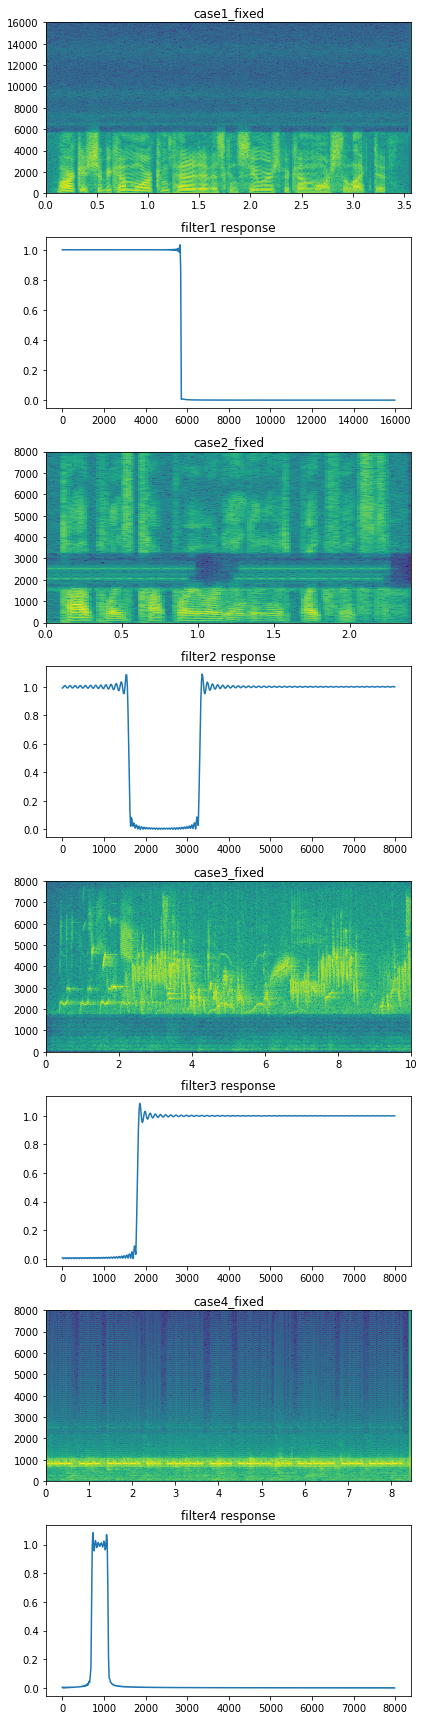

In [18]:
fig, (fig1_fixed_spec, fig1_filter, fig2_fixed_spec, fig2_filter, 
      fig3_fixed_spec, fig3_filter, fig4_fixed_spec, fig4_filter) = plt.subplots(nrows=8)

case1_lowpass = np.empty(1025, dtype=float)
omega = 5700 / (sr1 / 2)
for i in range(1025):
    case1_lowpass[i] = omega * np.sinc((i - 512) * omega)
data1_fixed = np.convolve(case1_lowpass, data1, mode='same')
fixed_freq_1 = stft(data1_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig1_fixed_spec, fixed_freq_1, len(data1_fixed), sr1, "spectrogram", "case1_fixed")
sound( data1_fixed, rate=sr1, label='case1 fixed')
show_response(fig1_filter, signal.freqz(case1_lowpass, fs=sr1), title="filter1 response")

case2_bandstop = np.empty(257, dtype=float)
omega_c = 2450 / (sr2 / 2)
omega_b = 850 / (sr2 / 2)
for i in range(257):
    if i == 128:
        case2_bandstop[i] = 1 - 2 * math.cos(math.pi * (i - 128) * omega_c) * omega_b * np.sinc(omega_b * (i - 128))
    else:
        case2_bandstop[i] = -2 * math.cos(math.pi * (i - 128) * omega_c) * omega_b * np.sinc(omega_b * (i - 128))
data2_fixed = np.convolve(case2_bandstop, data2, mode='same')
fixed_freq_2 = stft(data2_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig2_fixed_spec, fixed_freq_2, len(data2_fixed), sr2, "spectrogram", "case2_fixed")
sound( data2_fixed, rate=sr2, label='case2 fixed')
show_response(fig2_filter, signal.freqz(case2_bandstop, fs=sr2), title="filter2 response")

case3_hipass = np.empty(257, dtype=float)
omega = 1800 / (sr3 / 2)
for i in range(257):
    if i == 128:
        case3_hipass[i] = 1 - omega * np.sinc((i - 128) * omega)
    else:
        case3_hipass[i] = -omega * np.sinc((i - 128) * omega)
data3_fixed = np.convolve(case3_hipass, data3, mode='same')
fixed_freq_3 = stft(data3_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig3_fixed_spec, fixed_freq_3, len(data3_fixed), sr3, "spectrogram", "case3_fixed")
sound( data3_fixed, rate=sr3, label='case3 fixed')
show_response(fig3_filter, signal.freqz(case3_hipass, fs=sr3), title="filter3 response")

case4_bandpass = np.empty(513, dtype=float)
omega_c = 900 / (sr4 / 2)
omega_b = 200 / (sr4 / 2)
for i in range(513):
    case4_bandpass[i] = 2 * math.cos(math.pi * (i - 256) * omega_c) * omega_b * np.sinc(omega_b * (i - 256))
data4_fixed = np.convolve(case4_bandpass, data4, mode='same')
fixed_freq_4 = stft(data4_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig4_fixed_spec, fixed_freq_4, len(data4_fixed), sr4, "spectrogram", "case4_fixed")
sound( data4_fixed, rate=sr4, label='case4 fixed')
show_response(fig4_filter, signal.freqz(case4_bandpass, fs=sr4), title="filter4 response")    

fig.set_size_inches(6, 24)
fig.tight_layout()
plt.show()


#### Applying  IIR Butterworth filters ####

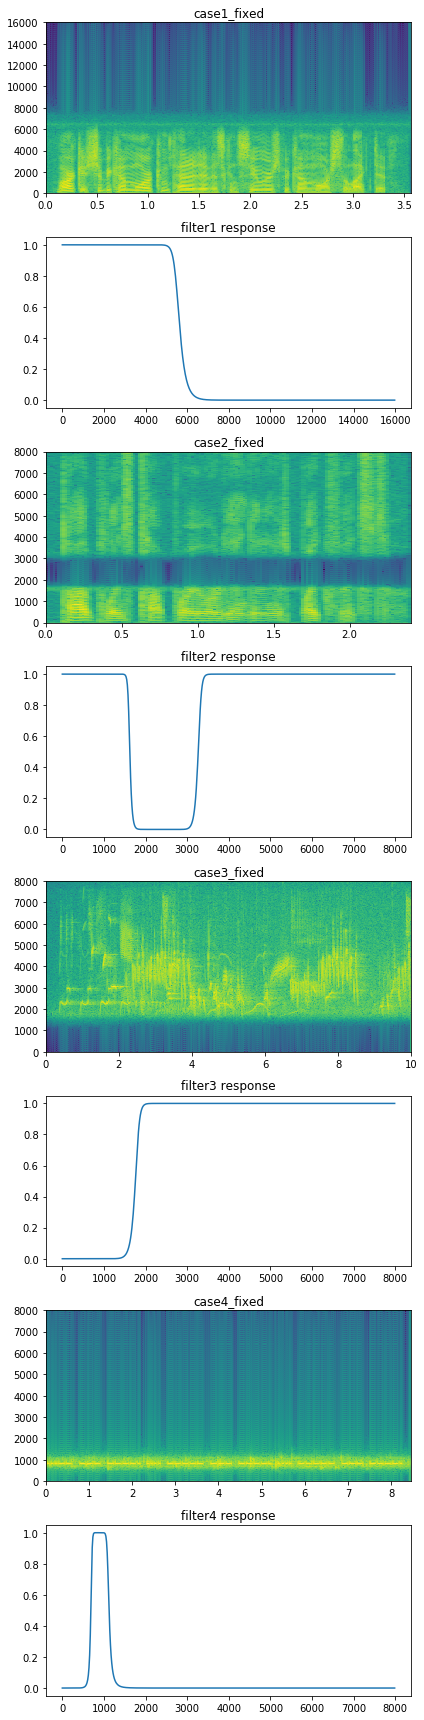

In [19]:
fig, (fig1_fixed_spec, fig1_filter, 
      fig2_fixed_spec, fig2_filter, 
      fig3_fixed_spec, fig3_filter, 
      fig4_fixed_spec, fig4_filter) = plt.subplots(nrows=8)


sos1 = signal.butter(20, 5500, 'lowpass', fs=sr1, output='sos')
b1, a1 = signal.butter(20, 5500, 'lowpass', fs=sr1)
data1_fixed = signal.sosfilt(sos1, data1)
fixed_freq_1 = stft(data1_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig1_fixed_spec, fixed_freq_1, len(data1_fixed), sr1, "spectrogram", "case1_fixed")
sound( data1_fixed, rate=sr1, label='case1 fixed')
show_response(fig1_filter, signal.freqz(b1, a1, fs=sr1), title="filter1 response")

sos2 = signal.butter(15, [1600, 3300], 'bandstop', fs=sr2, output='sos')
b2, a2 = signal.butter(15, [1600, 3300], 'bandstop', fs=sr2)
data2_fixed = signal.sosfilt(sos2, data2)
fixed_freq_2 = stft(data2_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig2_fixed_spec, fixed_freq_2, len(data2_fixed), sr2, "spectrogram", "case2_fixed")
sound( data2_fixed, rate=sr2, label='case2 fixed')
show_response(fig2_filter, signal.freqz(b2, a2, fs=sr2), title="filter2 response")

sos3 = signal.butter(20, 1800, 'highpass', fs=sr3, output='sos')
b3, a3 = signal.butter(20, 1800, 'highpass', fs=sr3)
data3_fixed = signal.sosfilt(sos3, data3)
fixed_freq_3 = stft(data3_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig3_fixed_spec, fixed_freq_3, len(data3_fixed), sr3, "spectrogram", "case3_fixed")
sound( data3_fixed, rate=sr3, label='case3 fixed')
show_response(fig3_filter, signal.freqz(b3, a3, fs=sr3), title="filter3 response")

sos4 = signal.butter(6, [700, 1100], 'bandpass', fs=sr4, output='sos')
b4, a4 = signal.butter(6, [700, 1100], 'bandpass', fs=sr4)
data4_fixed = signal.sosfilt(sos4, data4)
fixed_freq_4 = stft(data4_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig4_fixed_spec, fixed_freq_4, len(data4_fixed), sr4, "spectrogram", "case4_fixed")
sound( data4_fixed, rate=sr4, label='case4 fixed')
show_response(fig4_filter, signal.freqz(b4, a4, fs=sr4), title="filter4 response")

fig.set_size_inches(6, 24)
fig.tight_layout()
plt.show()




## Part 2. Designing a simple equalizer

For this part we will design a simple graphic equalizer. We will do so using a more straightforward approach as opposed to a bank of filters as discussed in class.

We want to make an equalizer which contains six bands with center frequencies at 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz. Your equalizer function will take two inputs, one for the input sound and a 6-element gain vector that will indicate how much to boost or suppress each frequency band. Use the ```scipy.signal.firwin2``` function to design a filter that has the desired characteristics. For various settings of the gain vector, use the ```scipy.signal.freqz``` command to plot the response of the filter and verify that it behaves as indicated. Experiment with various filter lengths and see which works best.

Once you figure that out, design a graphic equalizer with as many bands as you like (and arbitrary center frequencies as well), and use it to solve the problems in part 1 again. The only thing that should be different in the EQ for each recording should be the gains for each band. Play the output sounds, and show the spectrograms, see how they compare with your previous solutions.

Optional extra credit (+1pt): Use ipywidgets to make intective sliders and process an audio stream and play it from the speakers in real-time (either from mic input, or just stream audio from disk).

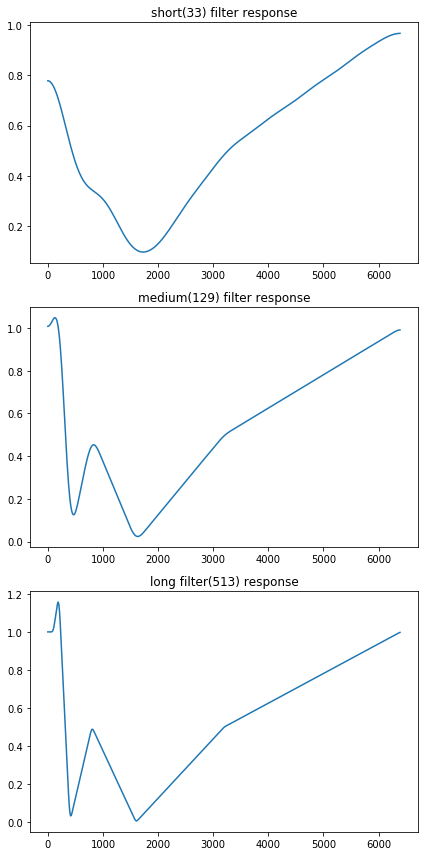

In [20]:
#eq_filter = signal.firwin2(33, [0, 0.2, 0.4, 0.6, 0.8, 1], [1.0, 1.0, 1.2, 0.0, 1.2, 1.0])
#show_response(plt, signal.freqz(eq_filter), title="filter4 response")
#plt.show()



# Design an equalizer function

fs = 12800
fig, (response_33, response_129, response_513) = plt.subplots(nrows=3)

eq_filter_33 = signal.firwin2(33, [0, 100, 200, 400, 800, 1600, 3200, int(fs/2)], [1.0, 1.0, 1.2, 0.0, 0.5, 0.0, 0.5, 1.0], fs=fs)
eq_filter_129 = signal.firwin2(129, [0, 100, 200, 400, 800, 1600, 3200, int(fs/2)], [1.0, 1.0, 1.2, 0.0, 0.5, 0.0, 0.5, 1.0], fs=fs)
eq_filter_513 = signal.firwin2(513, [0, 100, 200, 400, 800, 1600, 3200, int(fs/2)], [1.0, 1.0, 1.2, 0.0, 0.5, 0.0, 0.5, 1.0], fs=fs)

show_response(response_33, signal.freqz(eq_filter_33, fs=fs), title="short(33) filter response")
show_response(response_129, signal.freqz(eq_filter_129, fs=fs), title="medium(129) filter response")
show_response(response_513, signal.freqz(eq_filter_513, fs=fs), title="long filter(513) response")

fig.set_size_inches(6, 12)
fig.tight_layout()
plt.show()

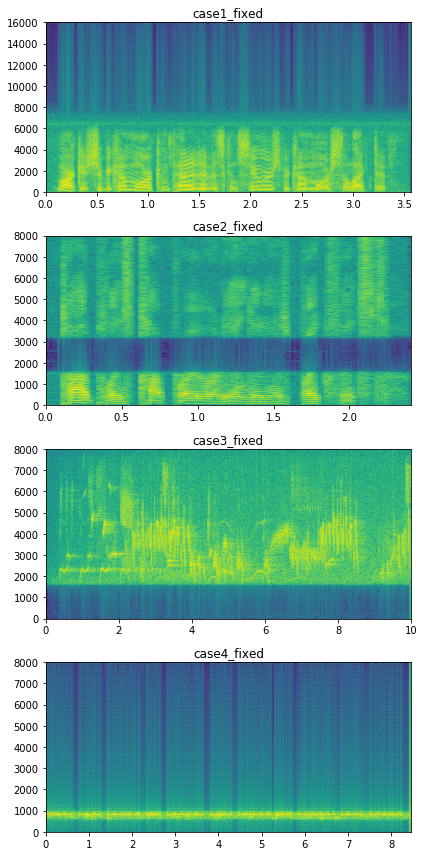

In [21]:

def equalizer( input_sound, gains, fs):
    freqs = np.arange(0, int(fs/2), 200)
    freqs = np.append(freqs, fs/2)
    eq_filter = signal.firwin2(1025, freqs, gains, fs=fs)
    return np.convolve(eq_filter, input_sound, mode='same')

fig, (fig1_fixed_spec,
      fig2_fixed_spec,
      fig3_fixed_spec,
      fig4_fixed_spec) = plt.subplots(nrows=4)


data1_eq = np.ones(math.ceil(int(sr1/2) / 200) + 1)
for i in range(30, len(data1_eq)):
    data1_eq[i] = 0.0
data1_fixed = equalizer(data1, data1_eq, sr1)
fixed_freq_2 = stft(data1_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig1_fixed_spec, fixed_freq_1, len(data1_fixed), sr1, "spectrogram", "case1_fixed")
sound( data1_fixed, rate=sr1, label='case1 fixed')

data2_eq = np.ones(math.ceil(int(sr2/2) / 200) + 1)
for i in range(8, 17):
    data2_eq[i] = 0.0
data2_fixed = equalizer(data2, data2_eq, sr2)
fixed_freq_2 = stft(data2_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig2_fixed_spec, fixed_freq_2, len(data2_fixed), sr2, "spectrogram", "case2_fixed")
sound( data2_fixed, rate=sr2, label='case2 fixed')

data3_eq = np.ones(math.ceil(int(sr3/2) / 200) + 1)
for i in range(0, 9):
    data3_eq[i] = 0.0
data3_fixed = equalizer(data3, data3_eq, sr3)
fixed_freq_3 = stft(data3_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig3_fixed_spec, fixed_freq_3, len(data3_fixed), sr3, "spectrogram", "case3_fixed")
sound( data3_fixed, rate=sr3, label='case3 fixed')

data4_eq = np.zeros(math.ceil(int(sr3/2) / 200) + 1)
for i in range(4, 5):
    data4_eq[i] = 1.0
data4_fixed = equalizer(data4, data4_eq, sr4)
fixed_freq_4 = stft(data4_fixed, dft_size, hop_size, zero_pad, window)
show_graph(fig4_fixed_spec, fixed_freq_4, len(data4_fixed), sr4, "spectrogram", "case4_fixed")
sound( data4_fixed, rate=sr4, label='case4 fixed')

fig.set_size_inches(6, 12)
fig.tight_layout()
plt.show()